In [13]:
import sklearn
import numpy as np
from numpy import ma
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import numpy.random as r
from sklearn.metrics import accuracy_score 

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow import keras

In [14]:
names =['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df = pd.read_csv('train.csv',header=None,sep=",",names=names, encoding = "ISO-8859-1")

names_test =['id', 'comment_text']
df_test = pd.read_csv('test.csv',header=None,sep=",",names=names_test, encoding = "ISO-8859-1")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
df['toxic_score'] = df[['toxic','severe_toxic','obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)
#drop unnecessary columns
df = df.drop(['id', 'toxic','severe_toxic','obscene', 'threat', 'insult', 'identity_hate'], axis=1)
#drop first row
df.drop(df.index[:1], inplace=True)

df_test = df_test.drop(['id'], axis=1)
df_test.drop(df_test.index[:1], inplace=True)
#df.drop(df.index[:150000], inplace=True) #smaller data set

In [16]:
# print(df)

In [17]:
df.head(5)
df_test.head(5)

,comment_text
1,Yo bitch Ja Rule is more succesful then you'll...
2,== From RfC == \n\n The title is fine as it is...
3,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
4,":If you have a look back at the source, the in..."
5,I don't anonymously edit articles at all.


In [18]:
bad_words = []
negative_file = open("negative-words.txt", "r")
for line in negative_file:
    bad_words.append(line.strip("\n"))
negative_file.close()
profanity_file = open("profanity-words.txt", "r")
for line in profanity_file:
    if (line.strip("\n") not in bad_words):
        bad_words.append(line.strip("\n"))
profanity_file.close()
# print(bad_words)

In [19]:
# because we have a lot of features, scaling the data set size down to 3000

data = df.values

X = data[:,0].reshape((159571,1))
Y = data[:,1].reshape((159571,1))

toxic_count = 0
not_toxic_count = 0
val_toxic = 0
val_not_toxic = 0
test_count = 0

X_training = []
Y_training = []
X_validation = []
Y_validation = []
X_testing = []
Y_testing = []

data_size = 15000

for index in range(0,159571):
    if ((int(Y[index][0]) == 1 and toxic_count < 0.5 * data_size) or 
        (int(Y[index][0]) == 0 and not_toxic_count < 0.5 * data_size)):
        Y_training.append(int(Y[index][0]))
        X_training.append(X[index][0])
        if (int(Y[index][0]) == 1):
            toxic_count += 1
        else:
            not_toxic_count += 1
    else:
        if ((int(Y[index][0]) == 1 and val_toxic < 0.5 * data_size) or 
            (int(Y[index][0]) == 0 and val_not_toxic < 0.5 * data_size)):
            Y_validation.append(int(Y[index][0]))
            X_validation.append(X[index][0])
            if (int(Y[index][0]) == 1):
                val_toxic += 1
            else:
                val_not_toxic += 1
        else:
            if(test_count < data_size * 2):
                Y_testing.append(int(Y[index][0]))
                X_testing.append(X[index][0])
                test_count += 1
    if (toxic_count + not_toxic_count == data_size and 
        val_toxic + val_not_toxic == data_size and 
        test_count == data_size * 2):
        break
                
# X_tr = np.array(X_tr).reshape((15000, 1))
Y_train = np.array(Y_training).reshape((data_size, 1))
Y_test = np.array(Y_testing).reshape((data_size * 2, 1))
Y_val = np.array(Y_validation).reshape((data_size, 1))


cv = sklearn.feature_extraction.text.CountVectorizer(vocabulary=bad_words)
X_train = cv.fit_transform(X_training).toarray()
X_test = cv.fit_transform(X_testing).toarray()
X_val = cv.fit_transform(X_validation).toarray()

# Neural Networks Not Scaled - Sigmoid

In [8]:
#using tensorflow to make the neural network
num_features = len(bad_words)

model = keras.Sequential()
model.add(keras.layers.Dense(units=num_features, input_shape=(num_features,)))
model.add(keras.layers.Dense(units=1500, activation=tf.nn.sigmoid))
model.add(keras.layers.Dense(units=1500, activation=tf.nn.sigmoid))
model.add(keras.layers.Dense(units=1, activation=tf.nn.sigmoid))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5213)              27180582  
_________________________________________________________________
dense_1 (Dense)              (None, 1500)              7821000   
_________________________________________________________________
dense_2 (Dense)              (None, 1500)              2251500   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1501      
Total params: 37,254,583
Trainable params: 37,254,583
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [10]:
training = model.fit(X_train,
                    Y_train,
                    epochs=30,
                    batch_size=500,
                    validation_data=(X_val, Y_val),
                    verbose=1)

Train on 15000 samples, validate on 15000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
15000/15000 [==============================] - 30s 2ms/sample - loss: 0.8821 - acc: 0.6425 - val_loss: 0.3690 - val_acc: 0.8563
Epoch 2/30
15000/15000 [==============================] - 29s 2ms/sample - loss: 0.3440 - acc: 0.8739 - val_loss: 0.3725 - val_acc: 0.8566
Epoch 3/30
15000/15000 [==============================] - 31s 2ms/sample - loss: 0.3016 - acc: 0.8917 - val_loss: 0.3866 - val_acc: 0.8563
Epoch 4/30
15000/15000 [==============================] - 31s 2ms/sample - loss: 0.2885 - acc: 0.8937 - val_loss: 0.3920 - val_acc: 0.8570
Epoch 5/30
15000/15000 [==============================] - 30s 2ms/sample - loss: 0.2789 - acc: 0.8975 - val_loss: 0.4023 - val_acc: 0.8545
Epoch 6/30
15000/15000 [==============================] - 30s 2ms/sample - loss: 0.2748 - acc: 0.8994 - val_loss: 0.4009 - val_acc: 0.8554
Epoch 7/30
15000/15000 [==============================] - 29s 2ms/sa

In [11]:
results = model.evaluate(X_test, Y_test)
print(results)

30000/30000 [==============================] - 23s 762us/sample - loss: 0.4588 - acc: 0.9144
[0.4587731474518776, 0.91443336]


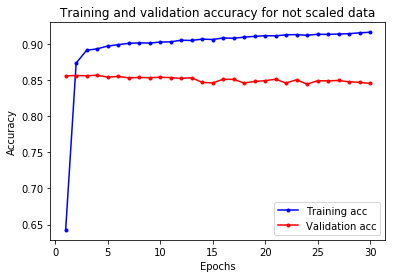

In [12]:
training_hist = training.history
train_acc = training_hist['acc']
val_acc = training_hist['val_acc']
plt.figure()   
num_epochs = range(1, len(train_acc) + 1)
plt.plot(num_epochs, train_acc, 'b.-', label='Training acc')
plt.plot(num_epochs, val_acc, 'r.-', label='Validation acc')
plt.title('Training and validation accuracy for not scaled data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Neural Network, Not Scaled, Regularization!

Doing L1 Regularization
C: 0.001
Instructions for updating:
Colocations handled automatically by placer.
Train on 15000 samples, validate on 15000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
15000/15000 [==============================] - 28s 2ms/sample - loss: 1.5923 - acc: 0.6409 - val_loss: 0.9873 - val_acc: 0.8541
Epoch 2/30
15000/15000 [==============================] - 28s 2ms/sample - loss: 0.8466 - acc: 0.8768 - val_loss: 0.8022 - val_acc: 0.8621
Epoch 3/30
15000/15000 [==============================] - 29s 2ms/sample - loss: 0.7042 - acc: 0.8903 - val_loss: 0.7201 - val_acc: 0.8615
Epoch 4/30
15000/15000 [==============================] - 29s 2ms/sample - loss: 0.6209 - acc: 0.8965 - val_loss: 0.6656 - val_acc: 0.8592
Epoch 5/30
15000/15000 [==============================] - 28s 2ms/sample - loss: 0.5662 - acc: 0.8981 - val_loss: 0.6358 - val_acc: 0.8562
Epoch 6/30
15000/15000 [==============================] - 28s 2ms/sample - loss: 0.5290 - acc: 0.8985 

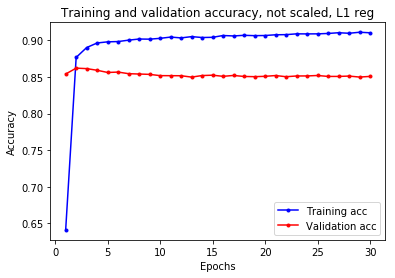

C: 0.01
Train on 15000 samples, validate on 15000 samples
Epoch 1/30
15000/15000 [==============================] - 29s 2ms/sample - loss: 6.3231 - acc: 0.5394 - val_loss: 3.3059 - val_acc: 0.5045
Epoch 2/30
15000/15000 [==============================] - 29s 2ms/sample - loss: 2.5213 - acc: 0.5143 - val_loss: 1.9909 - val_acc: 0.5026
Epoch 3/30
15000/15000 [==============================] - 1004s 67ms/sample - loss: 1.8176 - acc: 0.5001 - val_loss: 1.6958 - val_acc: 0.5000
Epoch 4/30
15000/15000 [==============================] - 32s 2ms/sample - loss: 1.6254 - acc: 0.5000 - val_loss: 1.5592 - val_acc: 0.5000
Epoch 5/30
15000/15000 [==============================] - 29s 2ms/sample - loss: 1.5118 - acc: 0.5000 - val_loss: 1.4667 - val_acc: 0.5000
Epoch 6/30
15000/15000 [==============================] - 29s 2ms/sample - loss: 1.4315 - acc: 0.5000 - val_loss: 1.3965 - val_acc: 0.5000
Epoch 7/30
15000/15000 [==============================] - 28s 2ms/sample - loss: 1.3692 - acc: 0.5000 - v

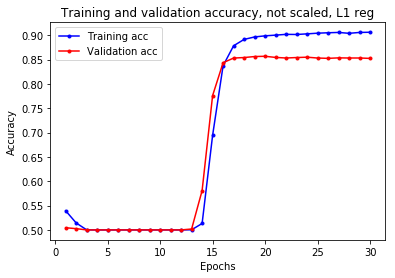

C: 0.1
Train on 15000 samples, validate on 15000 samples
Epoch 1/30
15000/15000 [==============================] - 30s 2ms/sample - loss: 57.9883 - acc: 0.4374 - val_loss: 30.6481 - val_acc: 0.5001
Epoch 2/30
15000/15000 [==============================] - 29s 2ms/sample - loss: 21.7784 - acc: 0.4989 - val_loss: 15.2373 - val_acc: 0.4999
Epoch 3/30
15000/15000 [==============================] - 29s 2ms/sample - loss: 12.5854 - acc: 0.4999 - val_loss: 10.6840 - val_acc: 0.4999
Epoch 4/30
15000/15000 [==============================] - 29s 2ms/sample - loss: 9.7408 - acc: 0.4577 - val_loss: 8.9059 - val_acc: 0.5000
Epoch 5/30
15000/15000 [==============================] - 28s 2ms/sample - loss: 8.3487 - acc: 0.5000 - val_loss: 7.8208 - val_acc: 0.5000
Epoch 6/30
15000/15000 [==============================] - 28s 2ms/sample - loss: 7.4659 - acc: 0.5000 - val_loss: 7.1143 - val_acc: 0.5000
Epoch 7/30
15000/15000 [==============================] - 28s 2ms/sample - loss: 6.8485 - acc: 0.5000 -

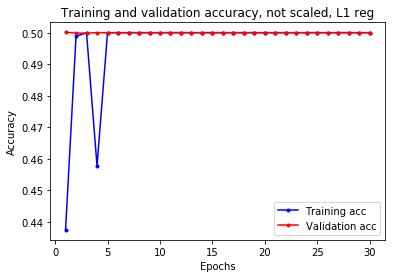

In [8]:
#using tensorflow to make the neural network
num_features = len(bad_words)

print("Doing L1 Regularization")
cvals = [0.001, 0.01, 0.1]
for c in cvals:
    print("C:", c)
    model_l1 = keras.Sequential()
    model_l1.add(keras.layers.Dense(units=num_features, input_shape=(num_features,)))
    model_l1.add(keras.layers.Dense(units=1500, activation=tf.nn.sigmoid, 
                                    activity_regularizer=tf.keras.regularizers.l1(l=c)))
    model_l1.add(keras.layers.Dense(units=1500, activation=tf.nn.sigmoid, 
                                    activity_regularizer=tf.keras.regularizers.l1(l=c)))
    model_l1.add(keras.layers.Dense(units=1, activation=tf.nn.sigmoid, 
                                    activity_regularizer=tf.keras.regularizers.l1(l=c)))
                 
    model_l1.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['acc'])
                 
    training_l1 = model_l1.fit(X_train,
                               Y_train,
                               epochs=30,
                               batch_size=500,
                               validation_data=(X_val, Y_val),
                               verbose=1)
    
    results_l1 = model_l1.evaluate(X_test, Y_test)
    print(results_l1)
                 
    train_l1_hist = training_l1.history
    train_l1_acc = train_l1_hist['acc']
    val_l1_acc = train_l1_hist['val_acc']
    plt.figure()   
    num_epochs_l1 = range(1, len(train_l1_acc) + 1)
    plt.plot(num_epochs_l1, train_l1_acc, 'b.-', label='Training acc')
    plt.plot(num_epochs_l1, val_l1_acc, 'r.-', label='Validation acc')
    plt.title('Training and validation accuracy, not scaled, L1 reg')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [9]:
def l2_regularization(c):
    num_features = len(bad_words)
    cvals = [0.001, 0.01, 0.1]
    print("C:", c)
    model_l2 = keras.Sequential()
    model_l2.add(keras.layers.Dense(units=num_features, input_shape=(num_features,)))
    model_l2.add(keras.layers.Dense(units=1500, activation=tf.nn.sigmoid, 
                                    activity_regularizer=tf.keras.regularizers.l2(l=c)))
    model_l2.add(keras.layers.Dense(units=1500, activation=tf.nn.sigmoid, 
                                    activity_regularizer=tf.keras.regularizers.l2(l=c)))
    model_l2.add(keras.layers.Dense(units=1, activation=tf.nn.sigmoid, 
                                    activity_regularizer=tf.keras.regularizers.l2(l=c)))
                 
    model_l2.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['acc'])
                 
    training_l2 = model_l2.fit(X_train,
                               Y_train,
                               epochs=30,
                               batch_size=500,
                               validation_data=(X_val, Y_val),
                               verbose=1)
    
    results_l2 = model_l2.evaluate(X_test, Y_test)
    print(results_l2)
                 
    train_l2_hist = training_l2.history
    train_l2_acc = train_l2_hist['acc']
    val_l2_acc = train_l2_hist['val_acc']
    plt.figure()   
    num_epochs_l2 = range(1, len(train_l2_acc) + 1)
    plt.plot(num_epochs_l2, train_l2_acc, 'b.-', label='Training acc')
    plt.plot(num_epochs_l2, val_l2_acc, 'r.-', label='Validation acc')
    plt.title('Training and validation accuracy, not scaled, L1 reg')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [10]:
print("Doing L2 Regularization")

Doing L2 Regularization


C: 0.001
Train on 15000 samples, validate on 15000 samples
Epoch 1/30
15000/15000 [==============================] - 30s 2ms/sample - loss: 1.0789 - acc: 0.6521 - val_loss: 0.5784 - val_acc: 0.8594
Epoch 2/30
15000/15000 [==============================] - 29s 2ms/sample - loss: 0.5169 - acc: 0.8791 - val_loss: 0.5205 - val_acc: 0.8640
Epoch 3/30
15000/15000 [==============================] - 29s 2ms/sample - loss: 0.4456 - acc: 0.8892 - val_loss: 0.4983 - val_acc: 0.8591
Epoch 4/30
15000/15000 [==============================] - 29s 2ms/sample - loss: 0.4112 - acc: 0.8945 - val_loss: 0.4905 - val_acc: 0.8588
Epoch 5/30
15000/15000 [==============================] - 29s 2ms/sample - loss: 0.3900 - acc: 0.8969 - val_loss: 0.4838 - val_acc: 0.8575
Epoch 6/30
15000/15000 [==============================] - 29s 2ms/sample - loss: 0.3737 - acc: 0.9005 - val_loss: 0.4799 - val_acc: 0.8563
Epoch 7/30
15000/15000 [==============================] - 28s 2ms/sample - loss: 0.3613 - acc: 0.9011 - val

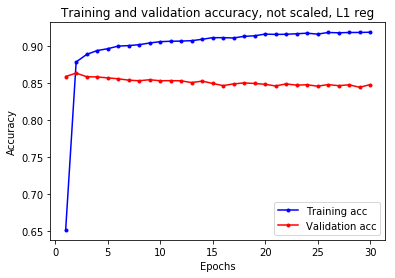

In [11]:
l2_regularization(0.001)

C: 0.01
Train on 15000 samples, validate on 15000 samples
Epoch 1/30
15000/15000 [==============================] - 31s 2ms/sample - loss: 2.8199 - acc: 0.6020 - val_loss: 1.3882 - val_acc: 0.7156
Epoch 2/30
15000/15000 [==============================] - 29s 2ms/sample - loss: 1.1362 - acc: 0.7143 - val_loss: 0.9460 - val_acc: 0.8291
Epoch 3/30
15000/15000 [==============================] - 28s 2ms/sample - loss: 0.8569 - acc: 0.8566 - val_loss: 0.7924 - val_acc: 0.8499
Epoch 4/30
15000/15000 [==============================] - 29s 2ms/sample - loss: 0.7209 - acc: 0.8747 - val_loss: 0.7169 - val_acc: 0.8532
Epoch 5/30
15000/15000 [==============================] - 29s 2ms/sample - loss: 0.6337 - acc: 0.8848 - val_loss: 0.6687 - val_acc: 0.8575
Epoch 6/30
15000/15000 [==============================] - 28s 2ms/sample - loss: 0.5789 - acc: 0.8910 - val_loss: 0.6402 - val_acc: 0.8553
Epoch 7/30
15000/15000 [==============================] - 29s 2ms/sample - loss: 0.5385 - acc: 0.8958 - val_

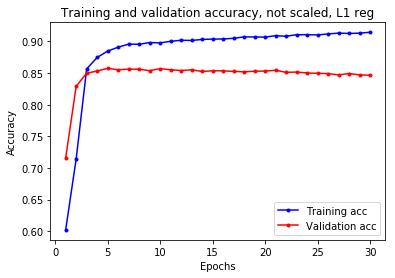

In [12]:
l2_regularization(0.01)

C: 0.1
Train on 15000 samples, validate on 15000 samples
Epoch 1/30
15000/15000 [==============================] - 29s 2ms/sample - loss: 21.8064 - acc: 0.4844 - val_loss: 7.8598 - val_acc: 0.5001
Epoch 2/30
15000/15000 [==============================] - 29s 2ms/sample - loss: 5.7968 - acc: 0.5157 - val_loss: 4.5900 - val_acc: 0.5745
Epoch 3/30
15000/15000 [==============================] - 28s 2ms/sample - loss: 4.1451 - acc: 0.5481 - val_loss: 3.5849 - val_acc: 0.5821
Epoch 4/30
15000/15000 [==============================] - 28s 2ms/sample - loss: 3.3253 - acc: 0.6238 - val_loss: 3.0032 - val_acc: 0.6438
Epoch 5/30
15000/15000 [==============================] - 28s 2ms/sample - loss: 2.8175 - acc: 0.6280 - val_loss: 2.6825 - val_acc: 0.6015
Epoch 6/30
15000/15000 [==============================] - 28s 2ms/sample - loss: 2.5646 - acc: 0.6203 - val_loss: 2.5172 - val_acc: 0.6082
Epoch 7/30
15000/15000 [==============================] - 28s 2ms/sample - loss: 2.4257 - acc: 0.6551 - val_

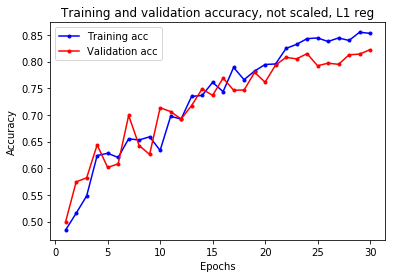

In [13]:
l2_regularization(0.1)

# Neural Networks Scaling - Sigmoid

In [14]:
X_scale = StandardScaler()
X_tr = X_scale.fit_transform(X_train)
X_te = X_scale.fit_transform(X_test)
X_va = X_scale.fit_transform(X_val)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by Stand

In [15]:
model_scale = keras.Sequential()
model_scale.add(keras.layers.Dense(units=num_features, input_shape=(num_features,)))
model_scale.add(keras.layers.Dense(units=1500, activation=tf.nn.sigmoid))
model_scale.add(keras.layers.Dense(units=1500, activation=tf.nn.sigmoid))
model_scale.add(keras.layers.Dense(units=1, activation=tf.nn.sigmoid))
model_scale.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['acc'])
model_scale.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 5213)              27180582  
_________________________________________________________________
dense_5 (Dense)              (None, 1500)              7821000   
_________________________________________________________________
dense_6 (Dense)              (None, 1500)              2251500   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 1501      
Total params: 37,254,583
Trainable params: 37,254,583
Non-trainable params: 0
_________________________________________________________________


In [16]:
train_scale = model_scale.fit(X_tr,
                              Y_train, 
                              epochs=30, 
                              batch_size=500, 
                              validation_data=(X_va, Y_val), 
                              verbose=1)

Train on 15000 samples, validate on 15000 samples
Epoch 1/30
15000/15000 [==============================] - 33s 2ms/sample - loss: 0.9162 - acc: 0.6145 - val_loss: 0.5771 - val_acc: 0.7013
Epoch 2/30
15000/15000 [==============================] - 31s 2ms/sample - loss: 0.4674 - acc: 0.7894 - val_loss: 0.5545 - val_acc: 0.7253
Epoch 3/30
15000/15000 [==============================] - 30s 2ms/sample - loss: 0.4167 - acc: 0.8145 - val_loss: 0.5831 - val_acc: 0.7351
Epoch 4/30
15000/15000 [==============================] - 29s 2ms/sample - loss: 0.3792 - acc: 0.8367 - val_loss: 0.5788 - val_acc: 0.7495
Epoch 5/30
15000/15000 [==============================] - 30s 2ms/sample - loss: 0.3576 - acc: 0.8452 - val_loss: 0.7465 - val_acc: 0.7342
Epoch 6/30
15000/15000 [==============================] - 31s 2ms/sample - loss: 0.3413 - acc: 0.8565 - val_loss: 0.6622 - val_acc: 0.7449
Epoch 7/30
15000/15000 [==============================] - 30s 2ms/sample - loss: 0.3154 - acc: 0.8701 - val_loss: 0.

In [19]:
results = model_scale.evaluate(X_te, Y_test)
print(results)

30000/30000 [==============================] - 24s 789us/sample - loss: 3.2830 - acc: 0.2852
[3.2830106524149576, 0.2852]


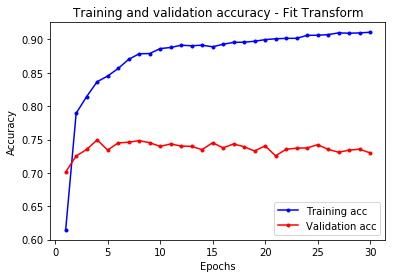

In [20]:
train_hist_scale = train_scale.history
train_acc_scale = train_hist_scale['acc']
val_acc_scale = train_hist_scale['val_acc']
plt.figure()   
num_epochs_scale = range(1, len(train_acc_scale) + 1)
plt.plot(num_epochs_scale, train_acc_scale, 'b.-', label='Training acc')
plt.plot(num_epochs_scale, val_acc_scale, 'r.-', label='Validation acc')
plt.title('Training and validation accuracy - Fit Transform')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Neural Network - Normalized Data

In [20]:
X_tr_norm = preprocessing.normalize(X_train)
X_te_norm = preprocessing.normalize(X_test)
X_va_norm = preprocessing.normalize(X_val)

In [12]:
num_features = len(bad_words)
model_norm = keras.Sequential()
model_norm.add(keras.layers.Dense(units=num_features, input_shape=(num_features,)))
model_norm.add(keras.layers.Dense(units=1500, activation=tf.nn.sigmoid))
model_norm.add(keras.layers.Dense(units=1500, activation=tf.nn.sigmoid))
model_norm.add(keras.layers.Dense(units=1, activation=tf.nn.sigmoid))
model_norm.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['acc'])
model_norm.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5213)              27180582  
_________________________________________________________________
dense_1 (Dense)              (None, 1500)              7821000   
_________________________________________________________________
dense_2 (Dense)              (None, 1500)              2251500   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1501      
Total params: 37,254,583
Trainable params: 37,254,583
Non-trainable params: 0
_________________________________________________________________


In [13]:
train_norm = model_norm.fit(X_tr_norm,
                            Y_train, 
                            epochs=30, 
                            batch_size=500, 
                            validation_data=(X_va_norm, Y_val), 
                            verbose=1)

Train on 15000 samples, validate on 15000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
15000/15000 [==============================] - 70s 5ms/sample - loss: 1.0611 - acc: 0.5873 - val_loss: 0.4011 - val_acc: 0.8543
Epoch 2/30
15000/15000 [==============================] - 67s 4ms/sample - loss: 0.3373 - acc: 0.8723 - val_loss: 0.3440 - val_acc: 0.8630
Epoch 3/30
15000/15000 [==============================] - 65s 4ms/sample - loss: 0.2908 - acc: 0.8914 - val_loss: 0.3638 - val_acc: 0.8598
Epoch 4/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 0.2781 - acc: 0.8937 - val_loss: 0.3668 - val_acc: 0.8583
Epoch 5/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 0.2742 - acc: 0.8975 - val_loss: 0.3782 - val_acc: 0.8565
Epoch 6/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 0.2709 - acc: 0.8987 - val_loss: 0.3806 - val_acc: 0.8564
Epoch 7/30
15000/15000 [==============================] - 65s 4ms/sa

In [14]:
results = model_norm.evaluate(X_te_norm, Y_test)
print(results)

30000/30000 [==============================] - 69s 2ms/sample - loss: 0.5168 - acc: 0.9106
[0.5168318375428518, 0.9105667]


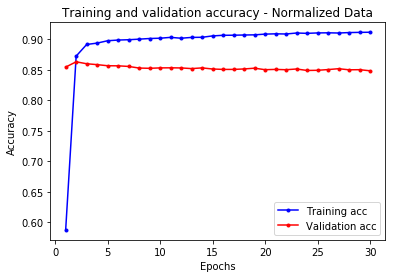

In [15]:
train_hist_norm = train_norm.history
train_acc_norm = train_hist_norm['acc']
val_acc_norm = train_hist_norm['val_acc']
plt.figure()   
num_epochs_norm = range(1, len(train_acc_norm) + 1)
plt.plot(num_epochs_norm, train_acc_norm, 'b.-', label='Training acc')
plt.plot(num_epochs_norm, val_acc_norm, 'r.-', label='Validation acc')
plt.title('Training and validation accuracy - Normalized Data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Doing L1 Regularization
C: 0.001
Train on 15000 samples, validate on 15000 samples
Epoch 1/30
15000/15000 [==============================] - 67s 4ms/sample - loss: 2.0597 - acc: 0.5847 - val_loss: 1.1130 - val_acc: 0.8475
Epoch 2/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 0.9570 - acc: 0.8711 - val_loss: 0.8769 - val_acc: 0.8657
Epoch 3/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 0.7662 - acc: 0.8898 - val_loss: 0.7580 - val_acc: 0.8641
Epoch 4/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 0.6598 - acc: 0.8955 - val_loss: 0.6886 - val_acc: 0.8625
Epoch 5/30
15000/15000 [==============================] - 67s 4ms/sample - loss: 0.5980 - acc: 0.8963 - val_loss: 0.6471 - val_acc: 0.8611
Epoch 6/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 0.5582 - acc: 0.8979 - val_loss: 0.6205 - val_acc: 0.8585
Epoch 7/30
15000/15000 [==============================] - 69s 5ms/sample - loss: 0.

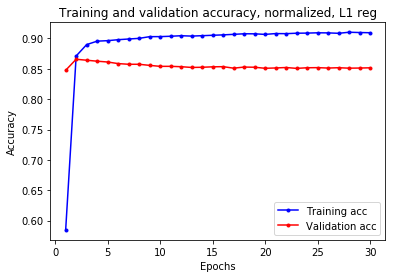

C: 0.01
Train on 15000 samples, validate on 15000 samples
Epoch 1/30
15000/15000 [==============================] - 70s 5ms/sample - loss: 6.3491 - acc: 0.5339 - val_loss: 3.7441 - val_acc: 0.7174
Epoch 2/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 3.0534 - acc: 0.5267 - val_loss: 2.5128 - val_acc: 0.5001
Epoch 3/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 2.1298 - acc: 0.5000 - val_loss: 1.8111 - val_acc: 0.5000
Epoch 4/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 1.6524 - acc: 0.5000 - val_loss: 1.5301 - val_acc: 0.5000
Epoch 5/30
15000/15000 [==============================] - 67s 4ms/sample - loss: 1.4712 - acc: 0.5156 - val_loss: 1.4217 - val_acc: 0.5000
Epoch 6/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 1.3822 - acc: 0.5000 - val_loss: 1.3493 - val_acc: 0.5000
Epoch 7/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 1.3195 - acc: 0.5000 - val_

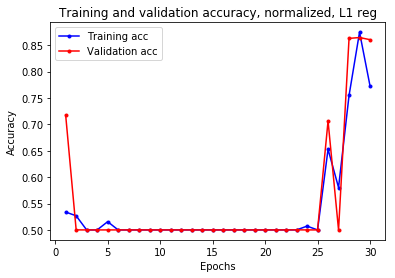

C: 0.1
Train on 15000 samples, validate on 15000 samples
Epoch 1/30
15000/15000 [==============================] - 69s 5ms/sample - loss: 56.3358 - acc: 0.5321 - val_loss: 31.2596 - val_acc: 0.5957
Epoch 2/30
15000/15000 [==============================] - 67s 4ms/sample - loss: 24.2613 - acc: 0.5336 - val_loss: 19.2451 - val_acc: 0.5069
Epoch 3/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 15.4821 - acc: 0.5153 - val_loss: 12.1358 - val_acc: 0.5000
Epoch 4/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 10.4282 - acc: 0.5000 - val_loss: 9.1475 - val_acc: 0.5000
Epoch 5/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 8.4328 - acc: 0.5000 - val_loss: 7.7962 - val_acc: 0.5000
Epoch 6/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 7.3532 - acc: 0.5000 - val_loss: 6.9433 - val_acc: 0.5000
Epoch 7/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 6.6540 - acc: 0.5000 

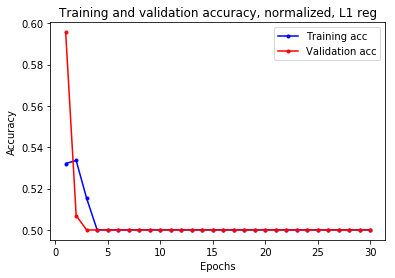

In [22]:
print("Doing L1 Regularization")
num_features = len(bad_words)
cvals = [0.001, 0.01, 0.1]
for c in cvals:
    print("C:", c)
    model_norm_l1 = keras.Sequential()
    model_norm_l1.add(keras.layers.Dense(units=num_features, input_shape=(num_features,)))
    model_norm_l1.add(keras.layers.Dense(units=1500, activation=tf.nn.sigmoid, 
                                    activity_regularizer=tf.keras.regularizers.l1(l=c)))
    model_norm_l1.add(keras.layers.Dense(units=1500, activation=tf.nn.sigmoid, 
                                    activity_regularizer=tf.keras.regularizers.l1(l=c)))
    model_norm_l1.add(keras.layers.Dense(units=1, activation=tf.nn.sigmoid, 
                                    activity_regularizer=tf.keras.regularizers.l1(l=c)))
                 
    model_norm_l1.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['acc'])
                 
    train_norm_l1 = model_norm_l1.fit(X_tr_norm,
                               Y_train,
                               epochs=30,
                               batch_size=500,
                               validation_data=(X_va_norm, Y_val),
                               verbose=1)
    
    print("Results:")
    results_norm_l1 = model_norm_l1.evaluate(X_te_norm, Y_test)
    print(results_norm_l1)
                 
    train_norm_l1_hist = train_norm_l1.history
    train_norm_l1_acc = train_norm_l1_hist['acc']
    val_norm_l1_acc = train_norm_l1_hist['val_acc']
    plt.figure()   
    num_epochs_norm_l1 = range(1, len(train_norm_l1_acc) + 1)
    plt.plot(num_epochs_norm_l1, train_norm_l1_acc, 'b.-', label='Training acc')
    plt.plot(num_epochs_norm_l1, val_norm_l1_acc, 'r.-', label='Validation acc')
    plt.title('Training and validation accuracy, normalized, L1 reg')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

Doing L2 Regularization
C: 0.001
Train on 15000 samples, validate on 15000 samples
Epoch 1/30
15000/15000 [==============================] - 71s 5ms/sample - loss: 1.3921 - acc: 0.6041 - val_loss: 0.6687 - val_acc: 0.8423
Epoch 2/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 0.5543 - acc: 0.8703 - val_loss: 0.5264 - val_acc: 0.8655
Epoch 3/30
15000/15000 [==============================] - 65s 4ms/sample - loss: 0.4618 - acc: 0.8906 - val_loss: 0.4950 - val_acc: 0.8641
Epoch 4/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 0.4239 - acc: 0.8943 - val_loss: 0.4790 - val_acc: 0.8608
Epoch 5/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 0.4008 - acc: 0.8970 - val_loss: 0.4715 - val_acc: 0.8605
Epoch 6/30
15000/15000 [==============================] - 65s 4ms/sample - loss: 0.3869 - acc: 0.8975 - val_loss: 0.4673 - val_acc: 0.8562
Epoch 7/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 0.

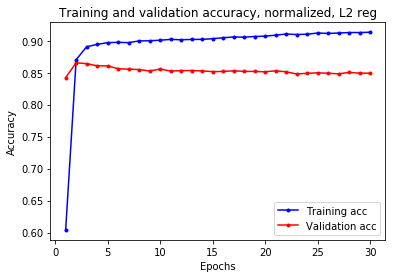

C: 0.01
Train on 15000 samples, validate on 15000 samples
Epoch 1/30
15000/15000 [==============================] - 68s 5ms/sample - loss: 2.7165 - acc: 0.5418 - val_loss: 1.2450 - val_acc: 0.7303
Epoch 2/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 1.0600 - acc: 0.6655 - val_loss: 0.9284 - val_acc: 0.8491
Epoch 3/30
15000/15000 [==============================] - 65s 4ms/sample - loss: 0.8594 - acc: 0.8680 - val_loss: 0.8138 - val_acc: 0.8495
Epoch 4/30
15000/15000 [==============================] - 65s 4ms/sample - loss: 0.7224 - acc: 0.8799 - val_loss: 0.6905 - val_acc: 0.8567
Epoch 5/30
15000/15000 [==============================] - 65s 4ms/sample - loss: 0.6087 - acc: 0.8868 - val_loss: 0.6234 - val_acc: 0.8586
Epoch 6/30
15000/15000 [==============================] - 67s 4ms/sample - loss: 0.5478 - acc: 0.8908 - val_loss: 0.5981 - val_acc: 0.8595
Epoch 7/30
15000/15000 [==============================] - 67s 4ms/sample - loss: 0.5114 - acc: 0.8946 - val_

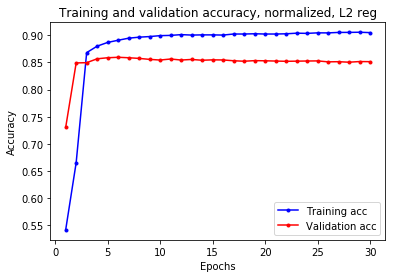

C: 0.1
Train on 15000 samples, validate on 15000 samples
Epoch 1/30
15000/15000 [==============================] - 69s 5ms/sample - loss: 20.3067 - acc: 0.4890 - val_loss: 6.8016 - val_acc: 0.5007
Epoch 2/30
15000/15000 [==============================] - 67s 4ms/sample - loss: 4.9213 - acc: 0.5033 - val_loss: 3.7335 - val_acc: 0.5003
Epoch 3/30
15000/15000 [==============================] - 65s 4ms/sample - loss: 3.3871 - acc: 0.5000 - val_loss: 3.0848 - val_acc: 0.5000
Epoch 4/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 2.8961 - acc: 0.5000 - val_loss: 2.7286 - val_acc: 0.5000
Epoch 5/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 2.6002 - acc: 0.5000 - val_loss: 2.4834 - val_acc: 0.5000
Epoch 6/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 2.3884 - acc: 0.5000 - val_loss: 2.2995 - val_acc: 0.5000
Epoch 7/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 2.2258 - acc: 0.5000 - val_

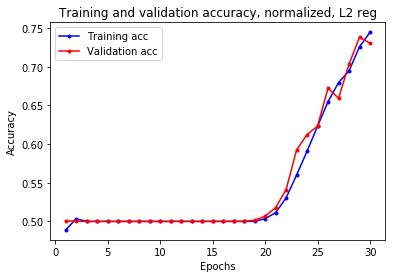

In [23]:
print("Doing L2 Regularization")
num_features = len(bad_words)
cvals = [0.001, 0.01, 0.1]
for c in cvals:
    print("C:", c)
    model_norm_l2 = keras.Sequential()
    model_norm_l2.add(keras.layers.Dense(units=num_features, input_shape=(num_features,)))
    model_norm_l2.add(keras.layers.Dense(units=1500, activation=tf.nn.sigmoid, 
                                    activity_regularizer=tf.keras.regularizers.l2(l=c)))
    model_norm_l2.add(keras.layers.Dense(units=1500, activation=tf.nn.sigmoid, 
                                    activity_regularizer=tf.keras.regularizers.l2(l=c)))
    model_norm_l2.add(keras.layers.Dense(units=1, activation=tf.nn.sigmoid, 
                                    activity_regularizer=tf.keras.regularizers.l2(l=c)))
                 
    model_norm_l2.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['acc'])
                 
    train_norm_l2 = model_norm_l2.fit(X_tr_norm,
                               Y_train,
                               epochs=30,
                               batch_size=500,
                               validation_data=(X_va_norm, Y_val),
                               verbose=1)
    
    print("Results:")
    results_norm_l2 = model_norm_l2.evaluate(X_te_norm, Y_test)
    print(results_norm_l2)
                 
    train_norm_l2_hist = train_norm_l2.history
    train_norm_l2_acc = train_norm_l2_hist['acc']
    val_norm_l2_acc = train_norm_l2_hist['val_acc']
    plt.figure()   
    num_epochs_norm_l2 = range(1, len(train_norm_l2_acc) + 1)
    plt.plot(num_epochs_norm_l2, train_norm_l2_acc, 'b.-', label='Training acc')
    plt.plot(num_epochs_norm_l2, val_norm_l2_acc, 'r.-', label='Validation acc')
    plt.title('Training and validation accuracy, normalized, L2 reg')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Min-Max Scaled Data

In [8]:
X_tr_mm = preprocessing.minmax_scale(X_train, feature_range=(0,1))
X_te_mm = preprocessing.minmax_scale(X_test, feature_range=(0,1))
X_va_mm = preprocessing.minmax_scale(X_val, feature_range=(0,1))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


In [11]:
num_features = len(bad_words)

modem_mm = keras.Sequential()
modem_mm.add(keras.layers.Dense(units=num_features, input_shape=(num_features,)))
modem_mm.add(keras.layers.Dense(units=1500, activation=tf.nn.sigmoid))
modem_mm.add(keras.layers.Dense(units=1500, activation=tf.nn.sigmoid))
modem_mm.add(keras.layers.Dense(units=1, activation=tf.nn.sigmoid))
modem_mm.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['acc'])
modem_mm.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5213)              27180582  
_________________________________________________________________
dense_1 (Dense)              (None, 1500)              7821000   
_________________________________________________________________
dense_2 (Dense)              (None, 1500)              2251500   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1501      
Total params: 37,254,583
Trainable params: 37,254,583
Non-trainable params: 0
_________________________________________________________________


In [12]:
train_mm = modem_mm.fit(X_tr_mm,
                        Y_train, 
                        epochs=30, 
                        batch_size=500, 
                        validation_data=(X_va_mm, Y_val), 
                        verbose=1)

Train on 15000 samples, validate on 15000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
15000/15000 [==============================] - 29s 2ms/sample - loss: 1.2916 - acc: 0.5015 - val_loss: 0.7541 - val_acc: 0.5000
Epoch 2/30
15000/15000 [==============================] - 27s 2ms/sample - loss: 0.6500 - acc: 0.5937 - val_loss: 0.5890 - val_acc: 0.6785
Epoch 3/30
15000/15000 [==============================] - 27s 2ms/sample - loss: 0.5168 - acc: 0.7373 - val_loss: 0.5860 - val_acc: 0.7008
Epoch 4/30
15000/15000 [==============================] - 28s 2ms/sample - loss: 0.4706 - acc: 0.7730 - val_loss: 0.5976 - val_acc: 0.7293
Epoch 5/30
15000/15000 [==============================] - 27s 2ms/sample - loss: 0.4445 - acc: 0.7866 - val_loss: 0.6200 - val_acc: 0.7347
Epoch 6/30
15000/15000 [==============================] - 29s 2ms/sample - loss: 0.4241 - acc: 0.7950 - val_loss: 0.6441 - val_acc: 0.7405
Epoch 7/30
15000/15000 [==============================] - 30s 2ms/sa

In [13]:
results = modem_mm.evaluate(X_te_mm, Y_test)
print(results)

30000/30000 [==============================] - 24s 801us/sample - loss: 1.2001 - acc: 0.8747
[1.200053024037679, 0.8746667]


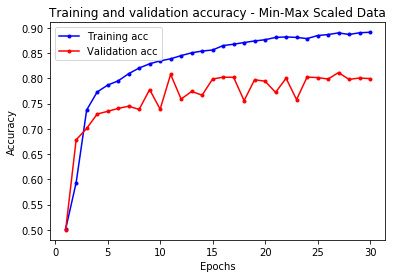

In [14]:
train_hist_mm = train_mm.history
train_acc_mm = train_hist_mm['acc']
val_acc_mm = train_hist_mm['val_acc']
plt.figure()   
num_epochs_mm = range(1, len(train_acc_mm) + 1)
plt.plot(num_epochs_mm, train_acc_mm, 'b.-', label='Training acc')
plt.plot(num_epochs_mm, val_acc_mm, 'r.-', label='Validation acc')
plt.title('Training and validation accuracy - Min-Max Scaled Data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Doing L1 Regularization
C: 0.001
Train on 15000 samples, validate on 15000 samples
Epoch 1/30
15000/15000 [==============================] - 74s 5ms/sample - loss: 1.7146 - acc: 0.4996 - val_loss: 1.2549 - val_acc: 0.5000
Epoch 2/30
15000/15000 [==============================] - 68s 5ms/sample - loss: 1.1151 - acc: 0.6108 - val_loss: 0.9972 - val_acc: 0.6964
Epoch 3/30
15000/15000 [==============================] - 67s 4ms/sample - loss: 0.8950 - acc: 0.7294 - val_loss: 0.8873 - val_acc: 0.7033
Epoch 4/30
15000/15000 [==============================] - 67s 4ms/sample - loss: 0.7808 - acc: 0.7575 - val_loss: 0.8318 - val_acc: 0.7125
Epoch 5/30
15000/15000 [==============================] - 71s 5ms/sample - loss: 0.7163 - acc: 0.7736 - val_loss: 0.8071 - val_acc: 0.7243
Epoch 6/30
15000/15000 [==============================] - 68s 5ms/sample - loss: 0.6748 - acc: 0.7875 - val_loss: 0.7859 - val_acc: 0.7325
Epoch 7/30
15000/15000 [==============================] - 67s 4ms/sample - loss: 0.

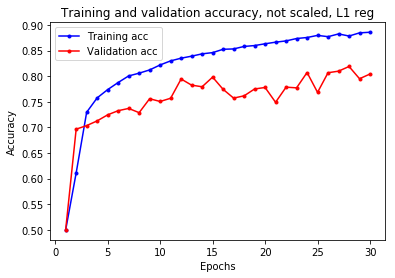

C: 0.01
Train on 15000 samples, validate on 15000 samples
Epoch 1/30
15000/15000 [==============================] - 69s 5ms/sample - loss: 6.5491 - acc: 0.5015 - val_loss: 3.7646 - val_acc: 0.5006
Epoch 2/30
15000/15000 [==============================] - 67s 4ms/sample - loss: 3.2307 - acc: 0.5143 - val_loss: 2.7194 - val_acc: 0.5031
Epoch 3/30
15000/15000 [==============================] - 67s 4ms/sample - loss: 2.3346 - acc: 0.5225 - val_loss: 1.9536 - val_acc: 0.5002
Epoch 4/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 1.7400 - acc: 0.5197 - val_loss: 1.5737 - val_acc: 0.5000
Epoch 5/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 1.4925 - acc: 0.5000 - val_loss: 1.4272 - val_acc: 0.5000
Epoch 6/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 1.3821 - acc: 0.5000 - val_loss: 1.3391 - val_acc: 0.5000
Epoch 7/30
15000/15000 [==============================] - 67s 4ms/sample - loss: 1.3065 - acc: 0.5000 - val_

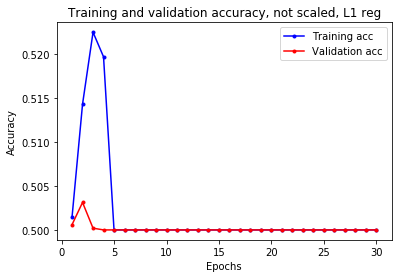

C: 0.1
Train on 15000 samples, validate on 15000 samples
Epoch 1/30
15000/15000 [==============================] - 70s 5ms/sample - loss: 57.8866 - acc: 0.5051 - val_loss: 31.0781 - val_acc: 0.5527
Epoch 2/30
15000/15000 [==============================] - 67s 4ms/sample - loss: 25.6453 - acc: 0.5045 - val_loss: 20.7109 - val_acc: 0.5000
Epoch 3/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 16.9226 - acc: 0.5000 - val_loss: 13.1176 - val_acc: 0.5000
Epoch 4/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 10.9332 - acc: 0.5000 - val_loss: 9.3088 - val_acc: 0.5000
Epoch 5/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 8.5673 - acc: 0.5000 - val_loss: 7.9249 - val_acc: 0.5000
Epoch 6/30
15000/15000 [==============================] - 66s 4ms/sample - loss: 7.4772 - acc: 0.5000 - val_loss: 7.0511 - val_acc: 0.5000
Epoch 7/30
15000/15000 [==============================] - 67s 4ms/sample - loss: 6.7276 - acc: 0.5000 

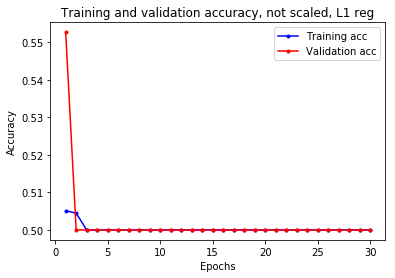

In [10]:
print("Doing L1 Regularization")
num_features = len(bad_words)
cvals = [0.001, 0.01, 0.1]
for c in cvals:
    print("C:", c)
    model_mm_l1 = keras.Sequential()
    model_mm_l1.add(keras.layers.Dense(units=num_features, input_shape=(num_features,)))
    model_mm_l1.add(keras.layers.Dense(units=1500, activation=tf.nn.sigmoid, 
                                    activity_regularizer=tf.keras.regularizers.l1(l=c)))
    model_mm_l1.add(keras.layers.Dense(units=1500, activation=tf.nn.sigmoid, 
                                    activity_regularizer=tf.keras.regularizers.l1(l=c)))
    model_mm_l1.add(keras.layers.Dense(units=1, activation=tf.nn.sigmoid, 
                                    activity_regularizer=tf.keras.regularizers.l1(l=c)))
                 
    model_mm_l1.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['acc'])
                 
    train_mm_l1 = model_mm_l1.fit(X_tr_mm,
                               Y_train,
                               epochs=30,
                               batch_size=500,
                               validation_data=(X_va_mm, Y_val),
                               verbose=1)
    
    print("Results:")
    results_mm_l1 = model_mm_l1.evaluate(X_te_mm, Y_test)
    print(results_mm_l1)
                 
    train_mm_l1_hist = train_mm_l1.history
    train_mm_l1_acc = train_mm_l1_hist['acc']
    val_mm_l1_acc = train_mm_l1_hist['val_acc']
    plt.figure()   
    num_epochs_mm_l1 = range(1, len(train_mm_l1_acc) + 1)
    plt.plot(num_epochs_mm_l1, train_mm_l1_acc, 'b.-', label='Training acc')
    plt.plot(num_epochs_mm_l1, val_mm_l1_acc, 'r.-', label='Validation acc')
    plt.title('Training and validation accuracy, not scaled, L1 reg')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()